# Plot for GPT

In [1]:
def format_subplot(ax, grid_x=True):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if grid_x:
        ax.grid(linestyle='--', alpha=0.4)
    else:
        ax.grid(axis='y', linestyle='--', alpha=0.4)

Loaded pretrained model gpt2 into HookedTransformer


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

 98%|█████████▊| 98/100 [00:08<00:00, 15.19it/s]

Loaded pretrained model gpt2-medium into HookedTransformer


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Loaded pretrained model gpt2-large into HookedTransformer


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:27<00:00,  4.50it/s]

Loaded pretrained model gpt2-xl into HookedTransformer


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


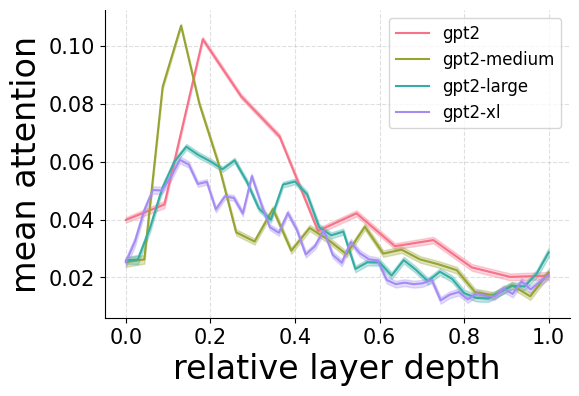

In [4]:
from transformers import AutoTokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
import torch
from transformer_lens import HookedTransformer, utils
import seaborn as sns
from datasets import load_dataset
import numpy as np
from tqdm import tqdm

torch.set_grad_enabled(False)

model_gpt = ["openai-community/gpt2", "openai-community/gpt2-medium", "openai-community/gpt2-large", "openai-community/gpt2-xl"]

# Initialize the plot
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 15})
# Define a color palette
colors = sns.color_palette("husl", len(model_gpt))

# Function to compute means of sub-diagonals ( we do not include bos token)
def extract_top_k_sub_diagonals_mean(matrix, k):
    sub_diagonals_means = []
    for head in range(matrix.shape[0]):
        for i in range(1, k + 1):
            sub_diagonal = np.diag(matrix[head], k=-i)
            sub_diagonals_means.extend(sub_diagonal)
    return np.nanmean(sub_diagonals_means)

top_k = 5
amount = 100

# Loop over each model and generate the plots
for idx, model_name in enumerate(model_gpt):
    # Clear torch cache
    torch.cuda.empty_cache()
    

    hooked_model = HookedTransformer.from_pretrained(model_name.split("/")[-1], device='cuda')
    n_layer = hooked_model.cfg.n_layers

    dataset = load_dataset("EleutherAI/the_pile_deduplicated", split='train', streaming=True)
    
    all_means = []
    pbar = tqdm(total=amount)
    for sample in dataset.take(amount):
        input = sample["text"]
        tokens = hooked_model.to_tokens(input)[:,:500]
        pattern_filter = lambda act_name: act_name.endswith("hook_pattern")
        logs, cache = hooked_model.run_with_cache(tokens, names_filter=pattern_filter)
        cache.to("cpu")
        vals = cache.stack_activation("pattern").detach().cpu().numpy()
        del cache
        means_all_layers = []
        for layer in range(vals.shape[0]):
            layer_vals = vals[layer, 0, :, :, :]
            means_all_layers.append(extract_top_k_sub_diagonals_mean(layer_vals, top_k))
        if np.all(np.isnan(means_all_layers)) or np.all(means_all_layers == 0):
            pbar.update(1)
            continue
        all_means.append(means_all_layers)
        pbar.update(1)

    mean_norms = np.mean(all_means, axis=0)
    sem_norms = np.std(all_means, axis=0) / np.sqrt(amount)

    # Calculate percentage of layers
    layer_percentage = np.arange(n_layer) / (n_layer - 1)

    # Plotting the results with error bars using matplotlib
    plt.plot(layer_percentage, mean_norms, label=model_name.split("/")[-1], color=colors[idx])

    # Adding the error bands
    plt.fill_between(layer_percentage, mean_norms - sem_norms, mean_norms + sem_norms, color=colors[idx], alpha=0.3)


    # Clear GPU memory after processing each model
    del hooked_model
    del mean_norms, sem_norms, all_means
    torch.cuda.empty_cache()

# Finalize the plot
plt.xlabel('relative layer depth'.lower(), fontsize=24)
plt.ylabel('Mean Attention'.lower(), fontsize=24)
# plt.title('Mean Attention per gpt layer on Previous 5 Tokens'.lower(), fontsize=22)
plt.legend(fontsize=12)
format_subplot(plt.gca())
plt.savefig("mean_attention_gpt.pdf")
plt.show()


# plot for pythia

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-410m-deduped into HookedTransformer


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:53<00:00,  1.17it/s]Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-1.4b-deduped into HookedTransformer


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:59<00:00,  1.19s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-2.8b-deduped into HookedTransformer


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:04<00:00,  2.53s/it]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-6.9b-deduped into HookedTransformer


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:27<00:00,  3.27s/it]


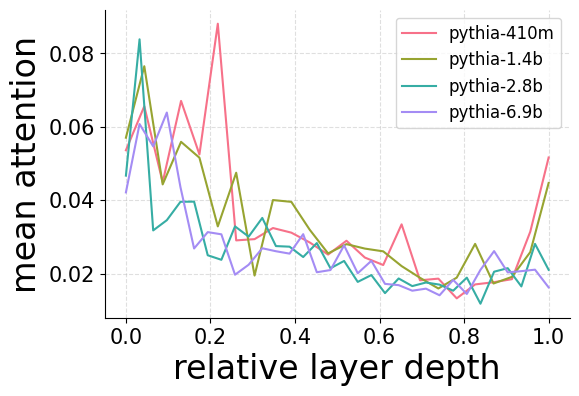

In [5]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import torch
from transformer_lens import HookedTransformer, utils
import seaborn as sns
from datasets import load_dataset
import numpy as np
from tqdm import tqdm

torch.set_grad_enabled(False)
model_pythia = ["pythia-410m-deduped", "pythia-1.4b-deduped", "pythia-2.8b-deduped", "pythia-6.9b-deduped"]

# Initialize the plot
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 15})

# Define a color palette
colors = sns.color_palette("husl", len(model_pythia))

# Function to compute means of sub-diagonals
def extract_top_k_sub_diagonals_mean(matrix, k):
    sub_diagonals_means = []
    for head in range(matrix.shape[0]):
        for i in range(1, k + 1):
            sub_diagonal = np.diag(matrix[head], k=-i)
            sub_diagonals_means.extend(sub_diagonal)
    return np.nanmean(sub_diagonals_means)

top_k = 5
amount = 100

# Loop over each model and generate the plots
for idx, model_name in enumerate(model_pythia):
    # Clear torch cache
    torch.cuda.empty_cache()
    
    hooked_model = HookedTransformer.from_pretrained(model_name, device='cuda:1')
    n_layer = hooked_model.cfg.n_layers

    dataset = load_dataset("EleutherAI/the_pile_deduplicated", split='train', streaming=True)
    
    all_means = []
    pbar = tqdm(total=amount)
    for sample in dataset.take(amount):
        input = sample["text"]
        pattern_filter = lambda act_name: act_name.endswith("hook_pattern")
        logs, cache = hooked_model.run_with_cache(input, names_filter=pattern_filter)
        cache.to("cpu")
        vals = cache.stack_activation("pattern").detach().cpu().numpy()
        del cache
        means_all_layers = []
        for layer in range(vals.shape[0]):
            layer_vals = vals[layer, 0, :, :, :]
            means_all_layers.append(extract_top_k_sub_diagonals_mean(layer_vals, top_k))
        if np.all(np.isnan(means_all_layers)) or np.all(means_all_layers == 0):
            pbar.update(1)
            continue
        all_means.append(means_all_layers)
        pbar.update(1)

    mean_norms = np.mean(all_means, axis=0)
    sem_norms = np.std(all_means, axis=0) / np.sqrt(amount)

    # Calculate percentage of layers
    layer_percentage = np.arange(n_layer) / (n_layer - 1)

    # Clean up model name for the plot label
    clean_model_name = model_name.replace("-deduped", "")

    # Plotting the results with error bars using matplotlib
    plt.plot(layer_percentage, mean_norms, label=clean_model_name, color=colors[idx])

    # Adding the error bands
    # plt.fill_between(layer_percentage, mean_norms - sem_norms, mean_norms + sem_norms, color=colors[idx], alpha=0.3)


    # Clear GPU memory after processing each model
    del hooked_model
    del mean_norms, sem_norms, all_means
    torch.cuda.empty_cache()

# Finalize the plot
plt.xlabel('relative layer depth'.lower(), fontsize=24)
plt.ylabel('Mean Attention'.lower(), fontsize=24)
# plt.title('Mean Attention per pythia layer on Previous 5 Tokens'.lower(), fontsize=22)
plt.legend(fontsize=12)
format_subplot(plt.gca())
plt.savefig("mean_attention_pythia.pdf")
plt.show()


Loaded pretrained model microsoft/phi-1 into HookedTransformer
24


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:51<00:00,  1.71s/it]

Loaded pretrained model microsoft/phi-1_5 into HookedTransformer
24


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model microsoft/phi-2 into HookedTransformer
32


Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:23<00:00,  1.95s/it]

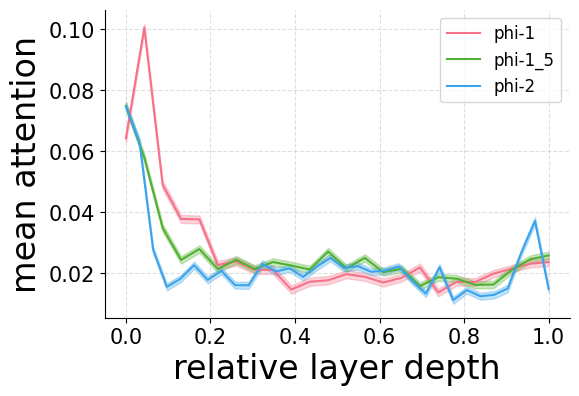

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from transformer_lens import HookedTransformer
import seaborn as sns
from datasets import load_dataset
import numpy as np
from tqdm import tqdm

torch.set_grad_enabled(False)
model_phi = ["microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2"]

# Initialize the plot
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 15})

# Define a color palette
colors = sns.color_palette("husl", len(model_phi))

# Function to compute means of sub-diagonals
def extract_top_k_sub_diagonals_mean(matrix, k):
    sub_diagonals_means = []
    for head in range(matrix.shape[0]):
        for i in range(1, k + 1):
            sub_diagonal = np.diag(matrix[head], k=-i)
            sub_diagonals_means.extend(sub_diagonal)
    return np.nanmean(sub_diagonals_means)

top_k = 5
amount = 100

# Loop over each model and generate the plots
for idx, model_name in enumerate(model_phi):
    # Clear torch cache
    torch.cuda.empty_cache()

    hf_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, use_fast=False, trust_remote_code=True)
    hf_model.eval().cuda()

    hooked_model = HookedTransformer.from_pretrained(model_name,
                                                     tokenizer=tokenizer,
                                                     fold_ln=True,
                                                     fold_value_biases=True,
                                                     center_writing_weights=True, device="cuda:1")
    n_layer = hooked_model.cfg.n_layers
    print(n_layer)
    dataset = load_dataset("EleutherAI/the_pile_deduplicated", split='train', streaming=True)

    all_means = []
    pbar = tqdm(total=amount)
    for sample in dataset.take(amount):
        input_text = sample["text"]
        pattern_filter = lambda act_name: act_name.endswith("hook_pattern")
        _, cache = hooked_model.run_with_cache(input_text, names_filter=pattern_filter)
        cache.to("cpu")
        vals = cache.stack_activation("pattern").detach().cpu().numpy()
        del cache
        torch.cuda.empty_cache()
        means_all_layers = []
        for layer in range(vals.shape[0]):
            layer_vals = vals[layer, 0, :, :, :]
            means_all_layers.append(extract_top_k_sub_diagonals_mean(layer_vals, top_k))
        if np.all(np.isnan(means_all_layers)) or np.all(means_all_layers == 0):
            pbar.update(1)
            continue
        all_means.append(means_all_layers)
        pbar.update(1)

    mean_norms = np.mean(all_means, axis=0)
    sem_norms = np.std(all_means, axis=0) / np.sqrt(amount)

    # Calculate percentage of layers
    layer_percentage = np.arange(n_layer) / (n_layer - 1)

    # Clean up model name for the plot label
    clean_model_name = model_name.replace("microsoft/", "")

    # Plotting the results with error bars using matplotlib
    plt.plot(layer_percentage, mean_norms, label=clean_model_name, color=colors[idx])

    # Adding the error bands
    plt.fill_between(layer_percentage, mean_norms - sem_norms, mean_norms + sem_norms, color=colors[idx], alpha=0.3)

    # Clear GPU memory after processing each model
    del hooked_model
    del hf_model
    del tokenizer
    torch.cuda.empty_cache()

# Finalize the plot
plt.xlabel('relative layer depth', fontsize=24)
plt.ylabel('Mean Attention'.lower(), fontsize=24)
# plt.title('Mean Attention per Phi layer on Previous 5 Tokens', fontsize=22)
plt.legend(fontsize=12)
format_subplot(plt.gca())
plt.savefig("mean_attention_phi.pdf")
plt.show()